In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('TMDB_movie_dataset_v11.csv')
df.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,adult,backdrop_path,...,original_language,original_title,overview,popularity,poster_path,tagline,genres,production_companies,production_countries,spoken_languages
0,27205,Inception,8.364,34495,Released,2010-07-15,825532764,148,False,/8ZTVqvKDQ8emSGUEMjsS4yHAwrp.jpg,...,en,Inception,"Cobb, a skilled thief who commits corporate es...",83.952,/oYuLEt3zVCKq57qu2F8dT7NIa6f.jpg,Your mind is the scene of the crime.,"Action, Science Fiction, Adventure","Legendary Pictures, Syncopy, Warner Bros. Pict...","United Kingdom, United States of America","English, French, Japanese, Swahili"
1,157336,Interstellar,8.417,32571,Released,2014-11-05,701729206,169,False,/pbrkL804c8yAv3zBZR4QPEafpAR.jpg,...,en,Interstellar,The adventures of a group of explorers who mak...,140.241,/gEU2QniE6E77NI6lCU6MxlNBvIx.jpg,Mankind was born on Earth. It was never meant ...,"Adventure, Drama, Science Fiction","Legendary Pictures, Syncopy, Lynda Obst Produc...","United Kingdom, United States of America",English
2,155,The Dark Knight,8.512,30619,Released,2008-07-16,1004558444,152,False,/nMKdUUepR0i5zn0y1T4CsSB5chy.jpg,...,en,The Dark Knight,Batman raises the stakes in his war on crime. ...,130.643,/qJ2tW6WMUDux911r6m7haRef0WH.jpg,Welcome to a world without rules.,"Drama, Action, Crime, Thriller","DC Comics, Legendary Pictures, Syncopy, Isobel...","United Kingdom, United States of America","English, Mandarin"
3,19995,Avatar,7.573,29815,Released,2009-12-15,2923706026,162,False,/vL5LR6WdxWPjLPFRLe133jXWsh5.jpg,...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",79.932,/kyeqWdyUXW608qlYkRqosgbbJyK.jpg,Enter the world of Pandora.,"Action, Adventure, Fantasy, Science Fiction","Dune Entertainment, Lightstorm Entertainment, ...","United States of America, United Kingdom","English, Spanish"
4,24428,The Avengers,7.710,29166,Released,2012-04-25,1518815515,143,False,/9BBTo63ANSmhC4e6r62OJFuK2GL.jpg,...,en,The Avengers,When an unexpected enemy emerges and threatens...,98.082,/RYMX2wcKCBAr24UyPD7xwmjaTn.jpg,Some assembly required.,"Science Fiction, Action, Adventure",Marvel Studios,United States of America,"English, Hindi, Russian"


In [3]:
df.shape

(939492, 23)

In [4]:
df.isna().any()

id                      False
title                    True
vote_average            False
vote_count              False
status                  False
release_date             True
revenue                 False
runtime                 False
adult                   False
backdrop_path            True
budget                  False
homepage                 True
imdb_id                  True
original_language       False
original_title           True
overview                 True
popularity              False
poster_path              True
tagline                  True
genres                   True
production_companies     True
production_countries     True
spoken_languages         True
dtype: bool

We can right away unnecessary columns, that for example contains links:

In [5]:
df.drop(columns=['backdrop_path', 'homepage', 'imdb_id', 'original_title', 'poster_path', 'tagline'], inplace=True)

### id, title

We can make a dictionary id - title and then drop title:

In [6]:
names = {}
for i in range(df.shape[0]):
    names[df.iloc[i]['id']] = df.iloc[i]['title']

In [7]:
df.drop(columns=['title'], inplace=True)

### vote_average

In [8]:
df.vote_average.describe()

count    939492.000000
mean          2.223660
std           3.150309
min           0.000000
25%           0.000000
50%           0.000000
75%           5.224000
max          10.000000
Name: vote_average, dtype: float64

In [9]:
df[df.vote_average == 0].shape[0]

594936

600k films out of 940k have no vote_average. Let's theck the distribution od non-zero estims: 

In [10]:
df[df.vote_average != 0].vote_average.describe()

count    344556.000000
mean          6.063198
std           1.944440
min           0.500000
25%           5.000000
50%           6.000000
75%           7.000000
max          10.000000
Name: vote_average, dtype: float64

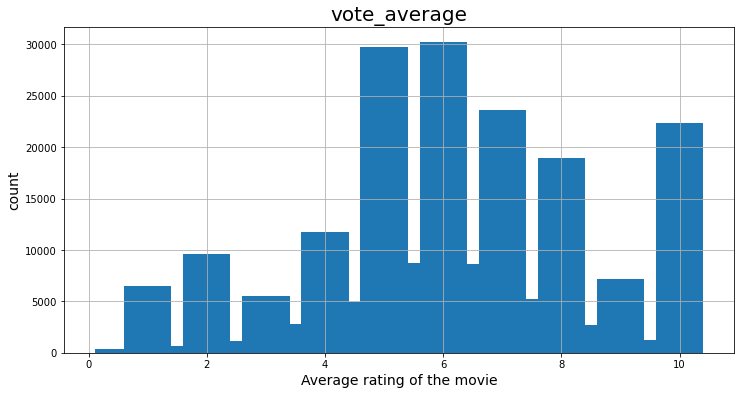

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(df[df.vote_average != 0].groupby('vote_average')['vote_average'].count().index),
      list(df[df.vote_average != 0].groupby('vote_average')['vote_average'].count().values))
plt.xlabel('Average rating of the movie', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('vote_average', fontsize=20)
ax.grid()
plt.show()

In [12]:
df = df[df.vote_average > 0]

There are obvious peaks at whole numbers. It explains why qurtiles are whole too. If we drop all whole numbers we get:

In [13]:
lst = list(set(df.vote_average.values) - set(range(0, 11)))
df[df.vote_average.isin(lst)].vote_average.describe()

count    179175.000000
mean          5.942778
std           1.375622
min           0.500000
25%           5.200000
50%           6.087000
75%           6.800000
max           9.980000
Name: vote_average, dtype: float64

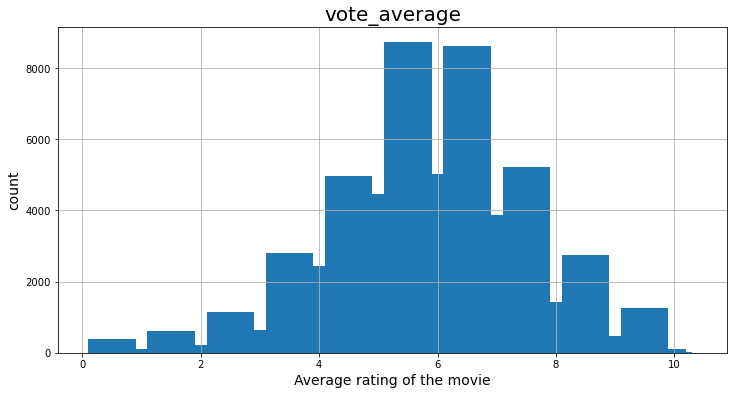

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(df[df.vote_average.isin(lst)].groupby('vote_average')['vote_average'].count().index),
      list(df[df.vote_average.isin(lst)].groupby('vote_average')['vote_average'].count().values))
plt.xlabel('Average rating of the movie', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('vote_average', fontsize=20)
ax.grid()
plt.show()

Now we can see peaks in a points like .2 and .8. Taking into account all the above we mat try multilabel classification instead of regression by combibning all the dots between n and n.(9) into one label n.

In [15]:
df['vote_label'] = df.vote_average.apply(int)

### vote_count

In [16]:
df[df.vote_count != 0].vote_count.describe()

count    344059.000000
mean         62.321294
std         576.577281
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max       34495.000000
Name: vote_count, dtype: float64

In [17]:
df = df[df.vote_count > 0]

### status

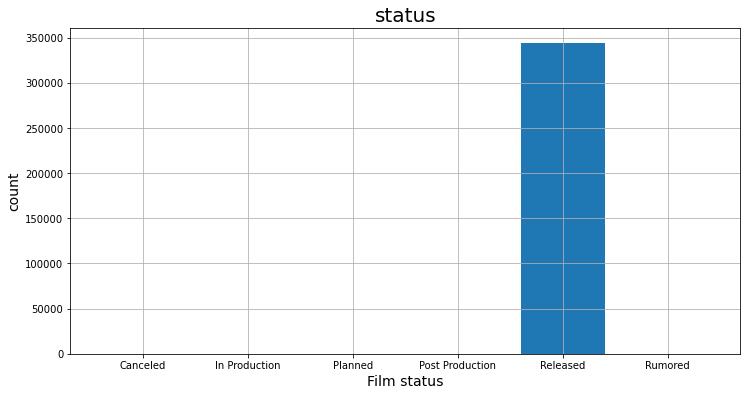

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(df.groupby('status')['status'].count().index),
      list(df.groupby('status')['status'].count().values))
plt.xlabel('Film status', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('status', fontsize=20)
ax.grid()
plt.show()

The majority of films are in "Released" status so let's make a binary feature: 1 if status = "Released" and 0 otherwise

In [19]:
df['status'] = df.status.apply(lambda x: 1 if x == 'Released' else 0)

### release_date

Drop all nans:

In [20]:
df.dropna(subset=['release_date'], inplace=True)

We can make some features from release date, e.g. year, month, quarter, etc:

In [21]:
df['year'] = df.release_date.apply(lambda x: int(x[:4]))

In [22]:
df['month'] = df.release_date.apply(lambda x: int(x[5:7]))

In [23]:
df['day'] = df.release_date.apply(lambda x: int(x[8:10]))

In [24]:
df['quarter'] = df.month.apply(lambda x: (x // 3) + 1)

In [25]:
df.drop(columns=['release_date'], inplace=True)

### revenue

In [26]:
df[df.revenue == 0].shape[0], df.shape[0]

(322008, 338266)

For most films the are no revenue data, so we can make a flag: 1 if revenue $\neq$ 0, 0 else

In [27]:
df['revenue'] = df.revenue.apply(lambda x: 1 if x != 0 else 0)

### runtime

In [28]:
df[df.runtime == 0].shape[0]

39999

We have 40k of missing values in runtime, so let's fill it with median:

In [29]:
df.loc[df.runtime == 0, 'runtime'] = np.median(df[df.runtime != 0].runtime.values)

### adult

In [30]:
df[df.adult == True].shape[0] / df.shape[0]

0.05591753235619305

Only about 5% of films are 18+, nethertheless we may still kepp it as a feature

In [31]:
df['adult'] = df.adult.apply(lambda x: 1 if x else 0)

### budget

In [32]:
df[df.budget == 0].shape[0]

312855

A lot of missing values, so we will do the exact same thing as with revenue:

In [33]:
df['budget'] = df.budget.apply(lambda x: 1 if x != 0 else 0)

### original_language

In [34]:
df.groupby('original_language')['original_language'].count().sort_values(ascending=False).head(10)

original_language
en    174685
fr     23679
es     23605
de     15023
ja     13510
it     10258
ru      7150
pt      6932
zh      5813
ko      4460
Name: original_language, dtype: int64

Let's highlight the 5 most popular languages and assign a label ot (others) to everyone else.

In [35]:
df['original_language'] = df.original_language.apply(lambda x: x if x in ['en', 'fr', 'es', 'de', 'ja', 'it'] else 'ot')

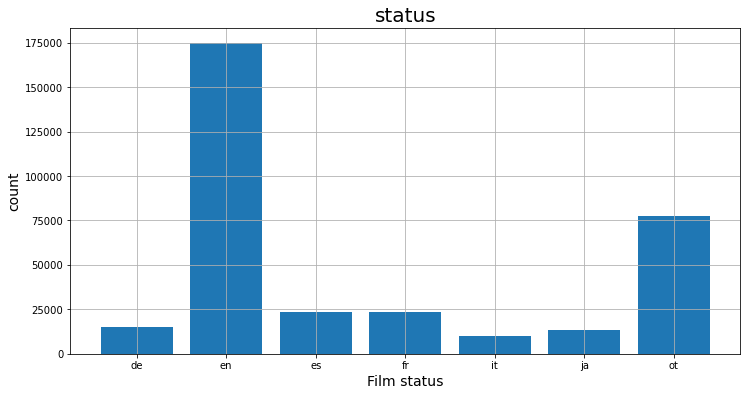

In [36]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(list(df.groupby('original_language')['original_language'].count().index),
      list(df.groupby('original_language')['original_language'].count().values))
plt.xlabel('Film status', fontsize=14)
plt.ylabel('count', fontsize=14)
plt.title('status', fontsize=20)
ax.grid()
plt.show()

Now and later we will encode all categorical features:

In [37]:
one_hot = pd.get_dummies(df['original_language'])
df.drop(columns=['original_language'], inplace=True)
df = df.join(one_hot)

### overview

We will make tokens from text description of a film and make features from it, but in another part of the project

### popularity

In [38]:
df[df.popularity == 0].shape[0]

754

Let's drop missing values:

In [39]:
df = df[df.popularity != 0]

### genres

In [40]:
df[df.genres.isna()].shape[0]

53427

Firstly, let's fill the missing values with 'no genres' label

In [41]:
df.loc[df.genres.isna(), 'genres'] = 'no genre'

Secondly, we can check the frequency of each genre and combine unpopular genres together: 

In [42]:
df['genres'] = df.genres.apply(lambda x: x.split(','))

In [43]:
def foo(lst):
    new_lst = []
    for item in lst:
        x = item.strip().lower()
        if x not in new_lst:
            new_lst.append(x)
            
    return new_lst

df['genres'] = df.genres.apply(foo)

In [44]:
genres = []
for item in list(df.genres):
    for it in item:
        if it not in genres:
            genres.append(it)
            
genres

['action',
 'science fiction',
 'adventure',
 'drama',
 'crime',
 'thriller',
 'fantasy',
 'comedy',
 'romance',
 'western',
 'mystery',
 'war',
 'animation',
 'family',
 'horror',
 'music',
 'history',
 'tv movie',
 'documentary',
 'no genre']

In [45]:
for genre in genres:
    cnt = 0
    for item in df.genres:
        if genre in item:
            cnt += 1
    print(f'{genre}: {cnt}')

action: 26350
science fiction: 11737
adventure: 14237
drama: 107337
crime: 19737
thriller: 28144
fantasy: 11598
comedy: 74127
romance: 30522
western: 4445
mystery: 10933
war: 5949
animation: 20926
family: 15254
horror: 24406
music: 18573
history: 8343
tv movie: 14055
documentary: 47238
no genre: 53427


Each genre is popular enough so no need to combine. Let's just do encoding:

In [46]:
for genre in genres:
    df[genre] = df.genres.apply(lambda x: 1 if genre in x else 0)
    
df.drop(columns=['genres'], inplace=True)

### production_companies

Strategy is the same as above

In [47]:
df[df.production_companies.isna()].shape[0]

114952

In [48]:
df.loc[df.production_companies.isna(), 'production_companies'] = 'no pc'

In [49]:
df['production_companies'] = df.production_companies.apply(lambda x: x.split(','))

In [50]:
df['production_companies'] = df.production_companies.apply(foo)

In [51]:
pcs = []
for item in list(df.production_companies):
    for it in item:
        if it not in pcs:
            pcs.append(it)
            
pcs[:10]

['legendary pictures',
 'syncopy',
 'warner bros. pictures',
 'lynda obst productions',
 'dc comics',
 'isobel griffiths',
 'dune entertainment',
 'lightstorm entertainment',
 '20th century fox',
 'ingenious media']

In [52]:
len(pcs) # here we need grouping for sure

94130

In [53]:
def bar(lst):
    new_lst = []
    for item in lst:
        if item in pcs:
            new_lst.append(item)
        else:
            new_lst.append('other_pcs')
    
    return list(set(new_lst))

In [54]:
pcs = ['no pc', 'warner bros. pictures',
'metro-goldwyn-mayer',
'paramount',
'columbia pictures',
'universal pictures',
'arte',
'20th century fox',
'bbc']

df['production_companies'] = df.production_companies.apply(bar)

for pc in pcs:
    df[pc] = df.production_companies.apply(lambda x: 1 if pc in x else 0)
    
df.drop(columns=['production_companies'], inplace=True)

### production_countries

In [55]:
df[df.production_countries.isna()].shape[0]

70351

In [56]:
df.loc[df.production_countries.isna(), 'production_countries'] = 'no country'

In [57]:
df['production_countries'] = df.production_countries.apply(lambda x: x.split(','))
df['production_countries'] = df.production_countries.apply(foo)

In [58]:
countries = []
for item in list(df.production_countries):
    for it in item:
        if it not in countries:
            countries.append(it)
            
countries[:10]

['united kingdom',
 'united states of america',
 'canada',
 'new zealand',
 'australia',
 'south africa',
 'france',
 'germany',
 'hong kong',
 'taiwan']

In [59]:
def bar(lst):
    new_lst = []
    for item in lst:
        if item in countries:
            new_lst.append(item)
        else:
            new_lst.append('other_countries')
    
    return list(set(new_lst))

In [60]:
countries = ['united states of america',
'no country',
'france',
'united kingdom',
'germany',
'japan',
'italy']

df['production_countries'] = df.production_countries.apply(bar)

for country in countries:
    df[country] = df.production_countries.apply(lambda x: 1 if country in x else 0)
    
df.drop(columns=['production_countries'], inplace=True)

### spoken_languages

In [61]:
df[df.spoken_languages.isna()].shape[0]

59561

In [62]:
df.loc[df.spoken_languages.isna(), 'spoken_languages'] = 'no language'

In [63]:
df['spoken_languages'] = df.spoken_languages.apply(lambda x: x.split(','))
df['spoken_languages'] = df.spoken_languages.apply(foo)

In [64]:
languages = []
for item in list(df.spoken_languages):
    for it in item:
        if it not in languages:
            languages.append(it)
            
languages[:10]

['english',
 'french',
 'japanese',
 'swahili',
 'mandarin',
 'spanish',
 'hindi',
 'russian',
 'xhosa',
 'persian']

In [65]:
def bar(lst):
    new_lst = []
    for item in lst:
        if item in languages:
            new_lst.append(item)
        else:
            new_lst.append('other_languages')
    
    return list(set(new_lst))

In [66]:
languages = ['english',
'no language',
'french',
'spanish',
'german',
'japanese',
'italian']

df['spoken_languages'] = df.spoken_languages.apply(bar)

for language in languages:
    df[language] = df.spoken_languages.apply(lambda x: 1 if language in x else 0)
    
df.drop(columns=['spoken_languages'], inplace=True)

### outliers detecting

Let's fit Isolation Forest on our data and drop outliers using this method.

In [69]:
X = df.drop(columns=['id', 'vote_average', 'overview']).values

In [71]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(random_state=0).fit(X)

In [73]:
pred = clf.predict(X)

In [74]:
np.unique(pred, return_counts=True)

(array([-1,  1]), array([  7899, 329613], dtype=int64))

In [79]:
df['flg'] = pred
df = df[df.flg == 1]
df.drop(columns=['flg'], inplace=True)

### normalizing integer values

It is common practice in machine learning to normalize integer regressors so let's make 2 datasets: with it and without.

In [80]:
df.to_csv('df.csv', sep=';', index=False)

In [81]:
df_normalized = df.copy()

In [82]:
scaler = StandardScaler()
abc = scaler.fit_transform(df_normalized[['vote_count', 'runtime', 'popularity']].values)
df_normalized['vote_count'] = abc.T[0]
df_normalized['runtime'] = abc.T[1]
df_normalized['popularity'] = abc.T[2]

In [83]:
df_normalized.to_csv('df_normalized.csv', sep=';', index=False)